# Rotation of the images of Pic Du Midi



## Import the pipeline

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import pandas as pd
import re

In [39]:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
#os.chdir(workbookDir)  # If you changed the current working dir, this will take you back to the workbook dir.

workbookDir: /Users/dagoret/MacOSX/GitHub/LSST/Spectractor/notebooks


In [40]:
import sys
sys.path.append(workbookDir)
sys.path.append(os.path.dirname(workbookDir))

In [41]:
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.logbook import LogBook
from spectractor.extractor.images import Image

if __name__ == "__main__":
    from argparse import ArgumentParser

    parser = ArgumentParser()
    parser.add_argument(dest="input", metavar='path', default=["tests/data/reduc_20170605_028.fits"],
                        help="Input fits file name. It can be a list separated by spaces, or it can use * as wildcard.",
                        nargs='*')
    parser.add_argument("-d", "--debug", dest="debug", action="store_true",
                        help="Enter debug mode (more verbose and plots).", default=False)
    parser.add_argument("-v", "--verbose", dest="verbose", action="store_true",
                        help="Enter verbose (print more stuff).", default=False)
    parser.add_argument("-o", "--output_directory", dest="output_directory", default="outputs/",
                        help="Write results in given output directory (default: ./outputs/).")
    parser.add_argument("-l", "--logbook", dest="logbook", default="ctiofulllogbook_jun2017_v5.csv",
                        help="CSV logbook file. (default: ctiofulllogbook_jun2017_v5.csv).")
    parser.add_argument("-c", "--config", dest="config", default="config/ctio.ini",
                        help="INI config file. (default: config.ctio.ini).")
    args = parser.parse_args()


# Configuration

In [42]:
FLAG_ROTATION=False

## Flags

In [43]:
parameters.VERBOSE = True
parameters.DEBUG = True

## Date

In [44]:
thedate="20190214"
#thedate="20190215"

In [45]:
! ls ../*.csv

../ctiofulllogbook_jun2017_V2.csv
../ctiofulllogbook_jun2017_v4.csv
../ctiofulllogbook_jun2017_v5.csv
../simple_logbook_PicDuMidi_20190214.csv
../simple_logbook_PicDuMidi_20190214_rot_v2.csv
../simple_logbook_PicDuMidi_20190214_v2.csv
../simple_logbook_PicDuMidi_20190214_v4.csv
../simple_logbook_PicDuMidi_20190215.csv
../simple_logbook_PicDuMidi_20190215_rot_v2.csv
../simple_logbook_PicDuMidi_20190215_v2.csv
../simple_logbook_PicDuMidi_20190215_v4.csv


## Logbook

In [46]:
if FLAG_ROTATION:
    logbookfilename="../simple_logbook_PicDuMidi_"+thedate+"_rot_v2.csv"
else:
    logbookfilename="../simple_logbook_PicDuMidi_"+thedate+"_v4.csv"
#logbookfilename="../ctiofulllogbook_jun2017_v5.csv" 

### Read the lobook to test

In [47]:
# good for my logbook
df=pd.read_csv(logbookfilename,sep=",", decimal=".", encoding='latin-1', header='infer')

### For example view the first selected filename for a reduced image 

In [48]:
df.file[0]

'T1M_20190214_234338_976_HD116405-Ronchi_Filtre_None_bin1x1.3_red.fit'

## Input filename

In [49]:
if thedate=="20190215":
    if FLAG_ROTATION:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v3"
    else:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4"
else:
    if FLAG_ROTATION:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v3"
    else:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v4"

In [50]:
if thedate=="20190215":
    if FLAG_ROTATION:
        file_name="T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_rot.fit"
    else:
        file_name="T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit"
else:
    if FLAG_ROTATION:
        file_name="T1M_20190214_234122_495_HD116405-Ronchi_Filtre_None_bin1x1.1_red_rot.fit"
    else:
        file_name="T1M_20190214_234338_976_HD116405-Ronchi_Filtre_None_bin1x1.3_red.fit"

## Output directory

In [51]:
output_directory="output/"+thedate

## Config

In [52]:
if FLAG_ROTATION:
    config="../config/picdumidirot.ini"
else:
    config="../config/picdumidi.ini"

# Run Logbook

In [53]:
df=pd.read_csv(logbookfilename)

In [54]:
df.head()

,Unnamed: 0,object,disperser,filt,evnum,flat,airmass,date,exposure,gain,ra,dec,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,file
0,0,HD116405,Ron145PDM19,None,3,FLAT_Filtre_None_bin1x1,1.355290,2019-02-14T23:43:38.976759,30.0,4.8,13.379287,44.7106,209.882324,188.262184,50.0,50.0,No,T1M_20190214_234338_976_HD116405-Ronchi_Filtre...
1,1,HD116405,Ron145PDM19,None,4,FLAT_Filtre_None_bin1x1,1.352314,2019-02-14T23:44:28.299483,30.0,4.8,13.379287,44.7106,208.021753,187.489457,50.0,50.0,No,T1M_20190214_234428_299_HD116405-Ronchi_Filtre...
2,2,HD116405,Holo150PDM19,None,1,FLAT_Filtre_None_bin1x1,1.012803,2019-02-15T02:53:58.927725,60.0,4.8,13.379287,44.7106,396.055504,332.850474,50.0,50.0,No,T1M_20190215_025358_927_HD116405-HOE200MM_Filt...
3,3,HD116405,Holo150PDM19,None,2,FLAT_Filtre_None_bin1x1,1.012259,2019-02-15T02:55:04.461868,60.0,4.8,13.379287,44.7106,413.757158,337.673023,50.0,50.0,No,T1M_20190215_025504_461_HD116405-HOE200MM_Filt...
4,4,HD116405,Holo150PDM19,None,3,FLAT_Filtre_None_bin1x1,1.011729,2019-02-15T02:56:09.821208,60.0,4.8,13.379287,44.7106,300.283642,192.527846,50.0,50.0,No,T1M_20190215_025609_821_HD116405-HOE200MM_Filt...


In [55]:
df.iloc[0]["file"]

'T1M_20190214_234338_976_HD116405-Ronchi_Filtre_None_bin1x1.3_red.fit'

In [56]:
logbook = LogBook(logbookfilename)

In [57]:
tag_file=file_name

In [58]:
disperser_label, target, xpos, ypos = logbook.search_for_image(tag_file)

In [59]:
disperser_label

'Ron145PDM19'

In [60]:
target

'HD116405'

In [61]:
xpos,ypos

(209, 188)

In [62]:
fullfilename=os.path.join(INPUTDIR,file_name)

In [63]:
fullfilename

'/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v4/T1M_20190214_234338_976_HD116405-Ronchi_Filtre_None_bin1x1.3_red.fit'

In [64]:
#assert False,"STOP" 

# Run Image

In [65]:
#Spectractor(fullfilename,output_directory, [xpos, ypos], target, disperser_label, config,logbook=logbookfilename)

- Need to specify we use Pic du Midi Observatory
- the logbook filename is hardcoded in Image constructor when calling Image constructor directly

In [66]:
parameters.OBS_NAME = 'PICDUMIDI'

In [67]:
img=Image(fullfilename,target=target,disperser_label=disperser_label,logbook=logbookfilename)

2019-04-11 16:35:47  Image      load_PDM_image       INFO   
	Loading Pic du Midi image /Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v4/T1M_20190214_234338_976_HD116405-Ronchi_Filtre_None_bin1x1.3_red.fit...
2019-04-11 16:35:47  Image      load_PDM_image       INFO   
	Image loaded
2019-04-11 16:35:47  Image      load_LogBook         INFO   
	Load Logbook  ../simple_logbook_PicDuMidi_20190214_v4.csv for /Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v4/T1M_20190214_234338_976_HD116405-Ronchi_Filtre_None_bin1x1.3_red.fit...
2019-04-11 16:35:47  Image      load_LogBook         INFO   
	Load Logbook  : date identified  SEL_DATE=20190214 for imagefile=/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v4/T1M_20190214_234338_976_HD116405-Ronchi_Filtre_None_bin1x1.3_red.fit, FLAG_ROTATION=False...
2019-04-11 16:35:47  Image      load_LogBook         WARNING 
	Load Logbook  :  tag_date = 20190214...
2019-04-11 16:35:47  Image      load_LogBook         WARNING 
	Load Logbook  :  tag_

Load disperser Ron145PDM19:
	from /Users/dagoret/MacOSX/GitHub/LSST/Spectractor/spectractor/extractor/dispersers/Ron145PDM19
Grating characteristics:
	N = 145.00 +/- 1.28 grooves/mm
	Average tilt of 45.0 degrees


2019-04-11 16:35:48  Star       load                 INFO   
	Simbad:  MAIN_ID        RA           DEC      ... SP_TYPE_4 SP_QUAL_4 SP_BIBCODE_4
             "h:m:s"       "d:m:s"    ...                                 
--------- ------------- ------------- ... --------- --------- ------------
HD 116405 13 22 45.1237 +44 42 53.911 ...       A0V         C             


Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_003.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_002.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_004.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_001.fits


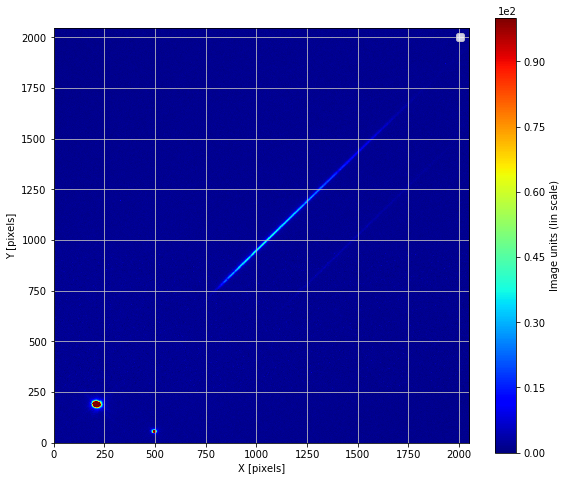

In [68]:
img.plot_image(vmax=100)

In [73]:
disperser_theta=img.disperser.theta_tilt

In [74]:
img.target_pixcoords